In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc,precision_score
from sklearn.decomposition import PCA

from sklearn.model_selection import learning_curve
import warnings 
warnings.filterwarnings("ignore")

Импортируем даннные и сохраняем в формате DataFrame.
Проверим, правильно ли распознались данные

In [2]:
df=pd.read_csv('data/data.csv')
df = df.drop(columns = 'id', axis =1)
df.head()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [3]:
df.shape

(699, 10)

Из описания данных было известно, что фича ***Bare_Nuclei имеет пропуски***. Проверим это

In [4]:
#сказать особенности данных: что нет сведений о паиенте и пр

In [5]:
df['Bare_Nuclei'].value_counts()

1     402
10    132
5      30
2      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: Bare_Nuclei, dtype: int64

Обнаружено 16 пропусков. Bare_Nuclei является важной характеристикой опухоли. Поэтому, чтобы не исказить показатели модели, наблюдения без указанного значения не войдут в итоговую выборку

In [6]:
df = df[df.Bare_Nuclei != '?']
df['Bare_Nuclei'].value_counts()

1     402
10    132
5      30
2      30
3      28
8      21
4      19
9       9
7       8
6       4
Name: Bare_Nuclei, dtype: int64

In [7]:
df.shape

(683, 10)

Посмотрим на описательные характеристики данных. Действительно, данные оценены корректно (минимальные баллы - 1, максимальный балл - 10)

In [8]:
df.describe()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.445095,2.869693,1.603221,2.699854
std,2.820761,3.065145,2.988581,2.864562,2.223085,2.449697,3.052666,1.732674,0.954592
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


Посмотрим на распределение переменных. Для этого построим парные графики каждой переменной

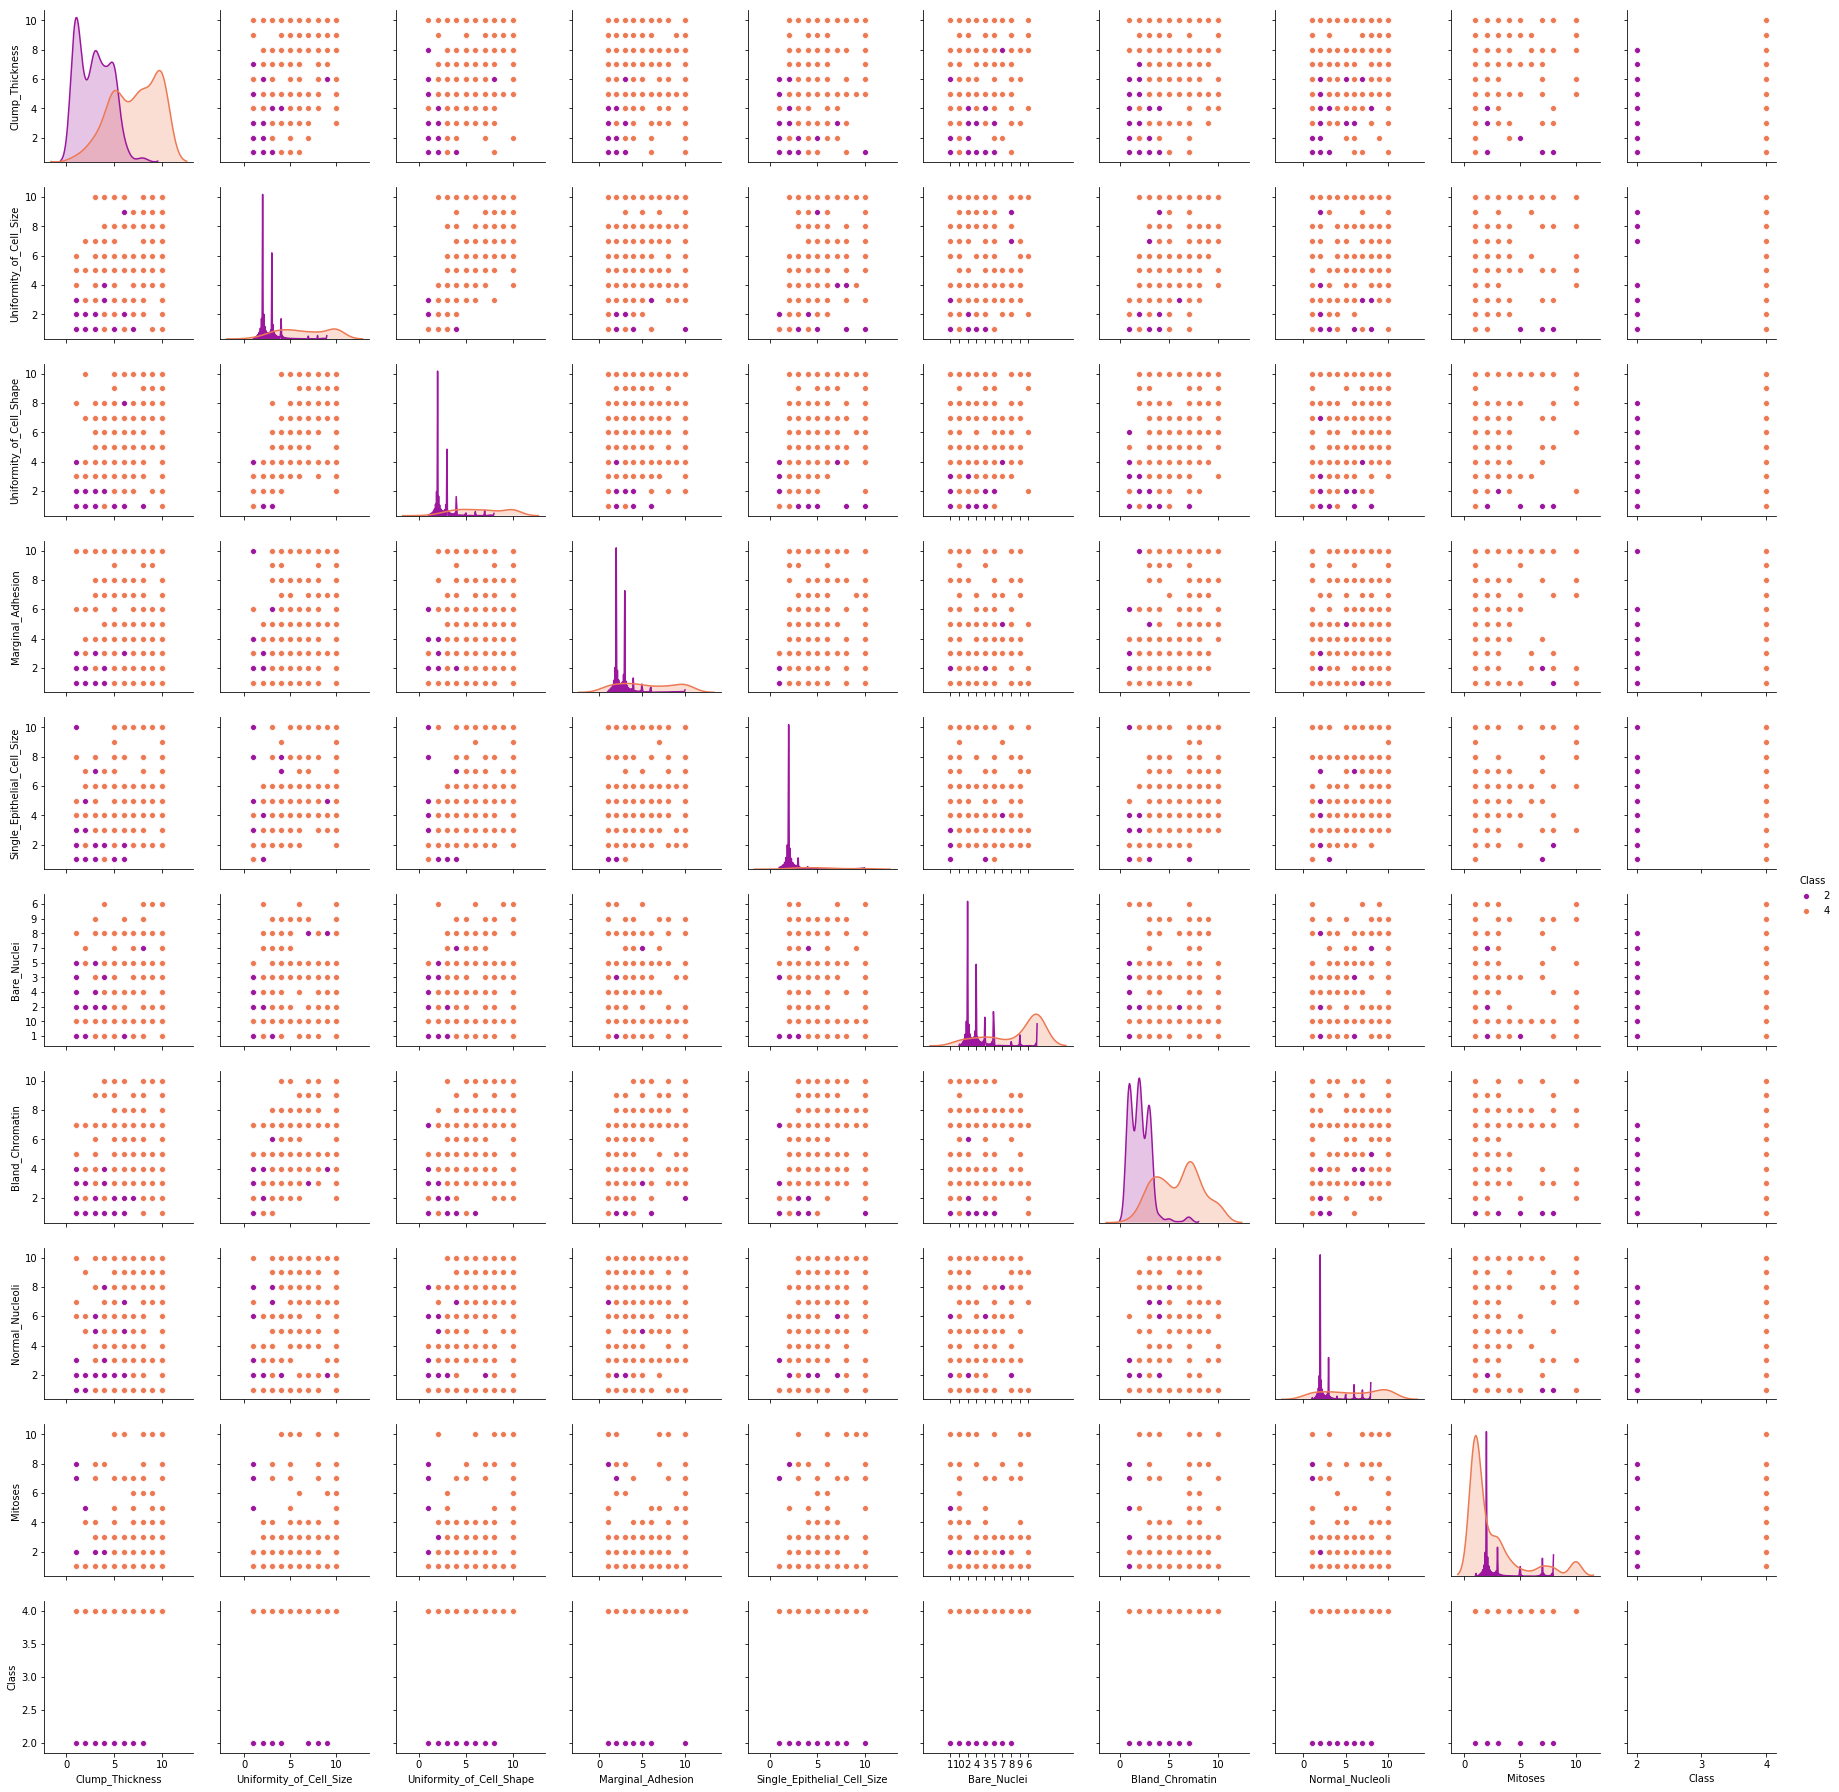

In [9]:
pairplot = sns.pairplot(df, hue="Class", palette='plasma')

Посмотрим на распределение целевых классов. В целом соотношение классов допустимое и не требует дополнительных преобразований. <br>  
Доля доброкачественных опухолей в выборке: 65.5%
<br>Доля злокачественных опухолей в выборке: 34.5%


In [10]:
df['Class'].value_counts()

2    444
4    239
Name: Class, dtype: int64

Заменим предложенные значения на стандартные: 0 - для доброкачественной опухоли, 1 - для злокачественной

In [11]:
df['Class'][df['Class'] == 4] = 1 
df['Class'][df['Class'] == 2] = 0

In [12]:
df['Class'].value_counts()

0    444
1    239
Name: Class, dtype: int64

Предположим наличие линейной зависимости между целевой переменной и признаками. Тогда можем построить корреляционную матрицу

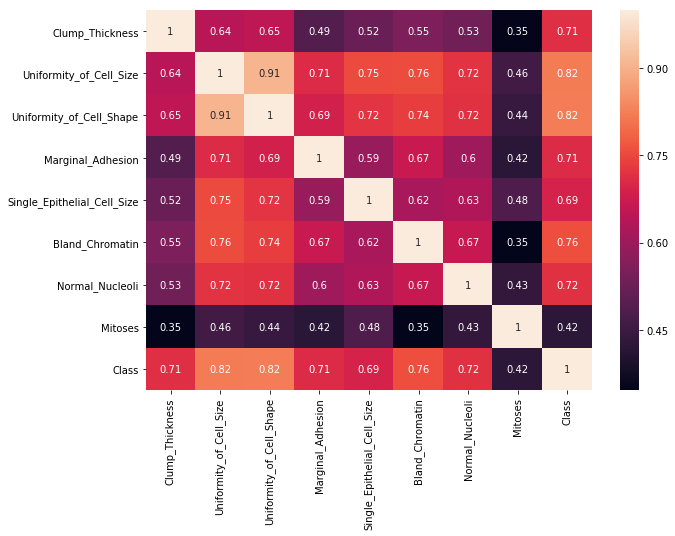

In [13]:
cor=df.corr()
plt.figure(figsize = (10,7))
sns.heatmap(cor, annot=True)

Гипотеза о наличии линейной зависимости принимается.

## Задача 1. Классификация пациентов ##
### Необходимо обучить модель на выборке, чтобы определять характер опухоли пациента по внесенным в карту данным (от врача-онколога).  ###

Теперь перейдем к первичному построению моделей. На основе которых будет выбрана 1-2 модели для их доработки.
1. Разделим данные на X и y
2. Разобъем выборку на тренировочную и валидационную
3. Из предположений о линейности и нормальности распределения, выполним скалирование данных
4. Построим дерево решений, ограничив глубину, чтобы избежать переобучение. Остальные параметры оставим неизменными

In [15]:
X = df.drop(columns=['Class'],axis=1)
y = df['Class']

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [73]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Модель 1. Дерево решений ###

In [18]:
#не надо

In [19]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(f'Decision Tree Accuracy: {round(clf.score(X_test, y_test), 4)*100}%')

Decision Tree Accuracy: 92.7%


### Модель 2. Логистическая регрессия ###

In [20]:
from sklearn.linear_model import LogisticRegression

In [30]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.predict(X_test)
acc = lr.score(X_test,y_test)
print(f'Logistic Regression Accuracy: {round(acc*100, 2)}%')

Logistic Regression Accuracy: 96.35%


### Модель 3. Случайный лес ###

In [31]:
rf = RandomForestClassifier(random_state=42, n_estimators=20)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print(f'Random Forest Accuracy: {round(accuracy_score(y_test, pred), 4)*100}%')

Random Forest Accuracy: 94.89%


### Модель 4. Градиентный бустинг ###

In [23]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier(learning_rate=0.1,iterations=5)
cb.fit(X_train,y_train)
print(f'Gradient Boosting Accuracy: {round(accuracy_score(y_test, cb.predict(X_test)), 4)*100}%')

0:	learn: 0.6215618	total: 123ms	remaining: 494ms
1:	learn: 0.5626153	total: 137ms	remaining: 206ms
2:	learn: 0.5113073	total: 150ms	remaining: 100ms
3:	learn: 0.4677086	total: 165ms	remaining: 41.2ms
4:	learn: 0.4310742	total: 180ms	remaining: 0us
Gradient Boosting Accuracy: 94.16%


### Модель 5. Байес ###

In [32]:
from sklearn.naive_bayes import GaussianNB 
bayes = GaussianNB() 
bayes.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [33]:
bayes.predict(X_test)
print(f'Bayes Accuracy: {round(bayes.score(X_test, y_test), 4)*100}%')

Bayes Accuracy: 95.62%


In [3]:
#+ вероятностная модель
#чекнуть значимость коэфов
#опорные вектора
#посмотреть архитектура сеток для поохжих задач + посмтотреть

Мы использовали метрику Accuarcy для первичного сравнения работы моделей. Логистическая регрессия и градиентный бустинг показали наилучшие результаты (97,14% и 97,14% соответственно). Поэтому, на следующем этапе мы будем проводить кросс валидацию на этих двух моделях.

## Тюнинг моделей ##

### Кросс-валидация логистической регрессии ###

В контексте задачи, наша цель - с большей вероятностью определить наличие злокачественной опухоли. Поэтому мы будем оптимизировать метрику presicion. Будем использовать Stratified Folds, чтобы сохранить распределение в подвыборках для оптимизации модели.

In [34]:
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

In [57]:
lr = LogisticRegression()
parameters = { 'penalty' : ['l1', 'l2'], 
'C' : np.logspace(-4, 4, 20)}

In [58]:
gridSearch = GridSearchCV(lr,parameters, n_jobs=-1, scoring='precision', cv=skf, verbose=10)
gridSearch = gridSearch.fit(X_train,y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0240s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    1.3s finished


In [59]:
lr_tuned = gridSearch.best_estimator_
lr_tuned.fit(X_train, y_train)
y_pred = lr_tuned.predict(X_test)

In [60]:
lr_tuned_pres = precision_score(y_test,y_pred)
print(f'Precision log reg tuned: {round(lr_tuned_pres, 4)*100}%')

Precision log reg tuned: 97.44%


In [61]:
coef = pd.DataFrame(lr_tuned.coef_[0], X.columns)
coef.columns = {'Coefficient'}
coef = coef.sort_values(['Coefficient'], ascending = False)
coef

,Coefficient
Bare_Nuclei,1.610964
Clump_Thickness,1.087988
Bland_Chromatin,0.973361
Mitoses,0.640652
Uniformity_of_Cell_Shape,0.590282
Normal_Nucleoli,0.490593
Marginal_Adhesion,0.469863
Uniformity_of_Cell_Size,0.152550
Single_Epithelial_Cell_Size,0.000000


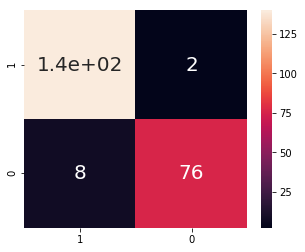

In [62]:
cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in "10"],
                  columns = [i for i in "10"])
plt.figure(figsize = (5,4))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20})

На оптимизированной логистической модели мы получили, что 2 человека, имеющих злокачественные опухоли были определены как "здоровые"

### Кросс-валидация градиентного бустинга ###

In [81]:
params = {
    'iterations': [20],
    'learning_rate': [0.01,0.1,1],
    'depth': [3,6,9] 
}
cb_tuned = GridSearchCV(cb,params,n_jobs=-1,scoring='precision',cv=skf,verbose=10)
cb_tuned.fit(X_train,y_train);


Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  85 out of  90 | elapsed:   10.9s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   11.2s finished


0:	learn: 0.6856900	total: 12.7ms	remaining: 242ms
1:	learn: 0.6791149	total: 29.6ms	remaining: 267ms
2:	learn: 0.6732042	total: 47.3ms	remaining: 268ms
3:	learn: 0.6668547	total: 64.1ms	remaining: 257ms
4:	learn: 0.6605980	total: 80.9ms	remaining: 243ms
5:	learn: 0.6543983	total: 98.9ms	remaining: 231ms
6:	learn: 0.6481502	total: 115ms	remaining: 214ms
7:	learn: 0.6425989	total: 135ms	remaining: 202ms
8:	learn: 0.6371906	total: 156ms	remaining: 190ms
9:	learn: 0.6317078	total: 174ms	remaining: 174ms
10:	learn: 0.6262425	total: 195ms	remaining: 160ms
11:	learn: 0.6200980	total: 226ms	remaining: 151ms
12:	learn: 0.6145494	total: 254ms	remaining: 137ms
13:	learn: 0.6089628	total: 273ms	remaining: 117ms
14:	learn: 0.6040654	total: 292ms	remaining: 97.2ms
15:	learn: 0.5988520	total: 309ms	remaining: 77.3ms
16:	learn: 0.5939467	total: 329ms	remaining: 58ms
17:	learn: 0.5890293	total: 350ms	remaining: 38.8ms
18:	learn: 0.5840867	total: 368ms	remaining: 19.4ms
19:	learn: 0.5793845	total: 385m

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=<catboost.core.CatBoostClassifier object at 0x0000021895B7D198>,
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'iterations': [20], 'learning_rate': [0.01, 0.1, 1], 'depth': [3, 6, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=10)

In [82]:
cb_best = cb_tuned.best_estimator_
cb_pred = cb_best.predict(X_test)

In [83]:
cb_tuned_pres = precision_score(y_test,cb_pred)
print(f'Precision log reg tuned: {round(cb_tuned_pres, 4)*100}%')

Precision log reg tuned: 98.11%


In [84]:
cb_best.feature_importances_

array([ 7.57680821, 15.27806863, 15.13705229,  5.78658691,  9.59678244,
       24.40956311,  8.20099515, 10.37423221,  3.63991106])

In [85]:
coef_cb = pd.DataFrame(cb_best.feature_importances_, X.columns)
coef_cb.columns = {'Coefficient'}
coef_cb = coef_cb.sort_values(['Coefficient'], ascending = False)
coef_cb

,Coefficient
Bare_Nuclei,24.409563
Uniformity_of_Cell_Size,15.278069
Uniformity_of_Cell_Shape,15.137052
Normal_Nucleoli,10.374232
Single_Epithelial_Cell_Size,9.596782
Bland_Chromatin,8.200995
Clump_Thickness,7.576808
Marginal_Adhesion,5.786587
Mitoses,3.639911


In [86]:
#попробовать на разных поддатасетах
#посмотреть п-статистику по фичам

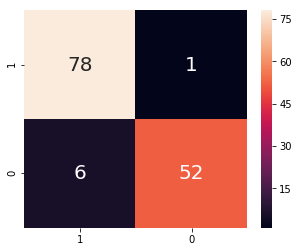

In [88]:
cm = confusion_matrix(y_test,cb_pred)
df_cm = pd.DataFrame(cm, index = [i for i in "10"],
                  columns = [i for i in "10"])
plt.figure(figsize = (5,4))
sns.heatmap(df_cm, annot=True,annot_kws={"size": 20})

На оптимизированной модели градиентного бустинга мы получили, что 2 человека, имеющих злокачественные опухоли были определены как "здоровые". Однако catboost  работаете немного медленнее, чем linreg.

In [103]:
# Нам удалось добиться улучшения в три наблюдения,
#которые ранее были классифицированы ошибочно как ложно отрицательные

In [42]:
# рисуем кривую обучения
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\LENOVO\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

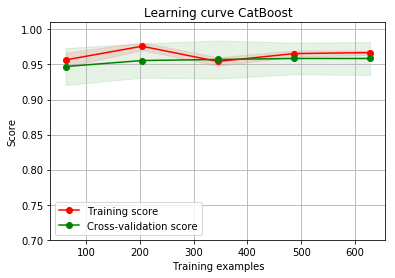

In [43]:
title = 'Learning curve CatBoost'
estimator = cb_tuned.best_estimator_

plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=skf, n_jobs=4)

вывод по задачке 1

In [95]:
from sklearn.cluster import KMeans

TypeError: fit() missing 1 required positional argument: 'X'

In [150]:
pca = PCA(n_components=0.95, random_state=17)
pca.fit(X_test)
X_pca = pca.transform(X_test)
pca.explained_variance_ratio_

array([0.63824317, 0.11685927, 0.06637342, 0.05114293, 0.04432324,
       0.03092674, 0.0266673 ])

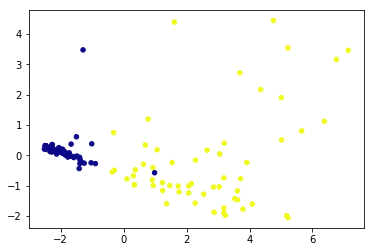

In [181]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_test, s=20, cmap='plasma');
plt.show()

#DBSCAN добавить

In [168]:
kmeans = KMeans(2,n_init =100, random_state=17)
kmeans.fit(X_test)
cluster_labels = kmeans.labels_

In [174]:
kmeans.labels_


array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0])

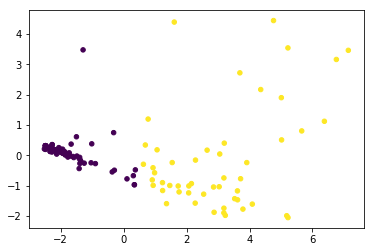

In [179]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans.labels_,s=20)
plt.show()

In [196]:
#%load ranking.py
"""
Implementation of pairwise ranking using scikit-learn LinearSVC

Reference: 

    "Large Margin Rank Boundaries for Ordinal Regression", R. Herbrich,
    T. Graepel, K. Obermayer 1999

    "Learning to rank from medical imaging data." Pedregosa, Fabian, et al., 
    Machine Learning in Medical Imaging 2012.


Authors: Fabian Pedregosa <fabian@fseoane.net>
         Alexandre Gramfort <alexandre.gramfort@inria.fr>

See also https://github.com/fabianp/pysofia for a more efficient implementation
of RankSVM using stochastic gradient descent methdos.
"""

import itertools
import numpy as np

from sklearn import svm, linear_model


def transform_pairwise(X, y):
    """Transforms data into pairs with balanced labels for ranking

    Transforms a n-class ranking problem into a two-class classification
    problem. Subclasses implementing particular strategies for choosing
    pairs should override this method.

    In this method, all pairs are choosen, except for those that have the
    same target value. The output is an array of balanced classes, i.e.
    there are the same number of -1 as +1

    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,) or (n_samples, 2)
        Target labels. If it's a 2D array, the second column represents
        the grouping of samples, i.e., samples with different groups will
        not be considered.

    Returns
    -------
    X_trans : array, shape (k, n_feaures)
        Data as pairs
    y_trans : array, shape (k,)
        Output class labels, where classes have values {-1, +1}
    """
    X_new = []
    y_new = []
    y = np.asarray(y)
    if y.ndim == 1:
        y = np.c_[y, np.ones(y.shape[0])]
    comb = itertools.combinations(range(X.shape[0]), 2)
    for k, (i, j) in enumerate(comb):
        if y[i, 0] == y[j, 0] or y[i, 1] != y[j, 1]:
            # skip if same target or different group
            continue
        X_new.append(X[i] - X[j])
        y_new.append(np.sign(y[i, 0] - y[j, 0]))
        # output balanced classes
        if y_new[-1] != (-1) ** k:
            y_new[-1] = - y_new[-1]
            X_new[-1] = - X_new[-1]
    return np.asarray(X_new), np.asarray(y_new).ravel()


class RankSVM(svm.LinearSVC):
    """Performs pairwise ranking with an underlying LinearSVC model

    Input should be a n-class ranking problem, this object will convert it
    into a two-class classification problem, a setting known as
    `pairwise ranking`.

    See object :ref:`svm.LinearSVC` for a full description of parameters.
    """

    def fit(self, X, y):
        """
        Fit a pairwise ranking model.

        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,) or (n_samples, 2)

        Returns
        -------
        self
        """
        X_trans, y_trans = transform_pairwise(X, y)
        super(RankSVM, self).fit(X_trans, y_trans)
        return self

    def decision_function(self, X):
        return np.dot(X, self.coef_.ravel())

    def predict(self, X):
        """
        Predict an ordering on X. For a list of n samples, this method
        returns a list from 0 to n-1 with the relative order of the rows of X.
        The item is given such that items ranked on top have are
        predicted a higher ordering (i.e. 0 means is the last item
        and n_samples would be the item ranked on top).

        Parameters
        ----------
        X : array, shape (n_samples, n_features)

        Returns
        -------
        ord : array, shape (n_samples,)
            Returns a list of integers representing the relative order of
            the rows in X.
        """
        if hasattr(self, 'coef_'):
            return np.argsort(np.dot(X, self.coef_.ravel()))
        else:
            raise ValueError("Must call fit() prior to predict()")

    def score(self, X, y):
        """
        Because we transformed into a pairwise problem, chance level is at 0.5
        """
        X_trans, y_trans = transform_pairwise(X, y)
        return np.mean(super(RankSVM, self).predict(X_trans) == y_trans)




## Задача 2. Ранжирование пациентов.##
### Из всех пациентов, определенных как "больные" необходимо определить приоритет каждого пациента, чтобы лечить наиболее опасные опухоли в первую очередь ###

In [185]:
mal_prob = lr_tuned.predict_proba(X_test)[:,1]
mal_prob = pd.DataFrame(mal_prob)
mal_prob.columns = ['Вероятность']
mal_prob['Приоритет'] = 0
mal_prob = mal_prob.sort_values(['Вероятность'], ascending = False)

#mal_prob[mal_prob['Вероятность'] >= 0.75]['Приоритет'] = 2 
mal_prob.values

array([[0.99999714, 0.        ],
       [0.99999508, 0.        ],
       [0.99998796, 0.        ],
       [0.99998616, 0.        ],
       [0.99997888, 0.        ],
       [0.99993356, 0.        ],
       [0.99985619, 0.        ],
       [0.99984076, 0.        ],
       [0.99981893, 0.        ],
       [0.9995107 , 0.        ],
       [0.99950099, 0.        ],
       [0.99943556, 0.        ],
       [0.99935364, 0.        ],
       [0.99928817, 0.        ],
       [0.99925725, 0.        ],
       [0.99923205, 0.        ],
       [0.99916653, 0.        ],
       [0.99872979, 0.        ],
       [0.9985515 , 0.        ],
       [0.99820664, 0.        ],
       [0.99745699, 0.        ],
       [0.99742856, 0.        ],
       [0.99738897, 0.        ],
       [0.99718958, 0.        ],
       [0.99535207, 0.        ],
       [0.9951407 , 0.        ],
       [0.99232026, 0.        ],
       [0.99185041, 0.        ],
       [0.99111524, 0.        ],
       [0.99065465, 0.        ],
       [0.

In [213]:
mal_prob = lr_tuned.predict_proba(X_test)[:,1]
mal_prob = pd.DataFrame(mal_prob)
mal_prob.values

array([[0.98035639],
       [0.99984076],
       [0.00559751],
       [0.00799739],
       [0.00372635],
       [0.03226136],
       [0.00549011],
       [0.06990179],
       [0.93563654],
       [0.01461091],
       [0.00247913],
       [0.01205778],
       [0.05628498],
       [0.03884007],
       [0.37396408],
       [0.99950099],
       [0.01803678],
       [0.96556591],
       [0.02867967],
       [0.99998616],
       [0.99820664],
       [0.02612067],
       [0.99935364],
       [0.00559751],
       [0.01444898],
       [0.00372635],
       [0.98739272],
       [0.99993356],
       [0.00543788],
       [0.33428417],
       [0.00247913],
       [0.9995107 ],
       [0.99738897],
       [0.96872464],
       [0.00551712],
       [0.00372635],
       [0.99998796],
       [0.00576977],
       [0.90851233],
       [0.81551709],
       [0.00816143],
       [0.99065465],
       [0.99925725],
       [0.00559751],
       [0.00559751],
       [0.97136767],
       [0.00559751],
       [0.995

In [ ]:
#вероятностная модель для мультиклассовой 

In [275]:
mal_prob[mal_prob['Вероятность']] 

KeyError: "None of [Float64Index([ 0.9964731999489324,  0.9929369528175512,  0.9890290954793411,\n                0.985293296243271,  0.9839409124626367,  0.9836805514694685,\n               0.9808554094041847,  0.9795439026645792,  0.9785219598773379,\n               0.9724047441839064,\n              ...\n              0.07888519303914948, 0.07139122905403567, 0.07139122905403567,\n              0.07139122905403567, 0.07139122905403567, 0.07139122905403567,\n              0.07139122905403567, 0.07139122905403567, 0.07139122905403567,\n              0.06668911877452169],\n             dtype='float64', length=140)] are in the [columns]"

In [265]:
for i in randge len(mal_prob):
    if()


In [216]:
mal_prob.columns = {'prob'}
mal_prob2 = mal_prob[mal_prob.prob > 0.5]

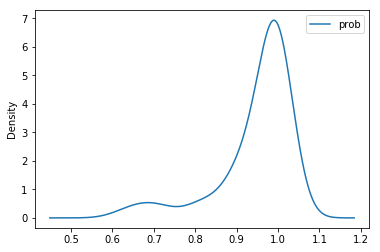

In [217]:
mal_prob2.plot(kind='kde')